In [2]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split, KFold

current_dir = os.getcwd()

data_paths = {
    "energies": os.path.join(current_dir, "../data", "energies.npy"),
    "2-body": os.path.join(current_dir, "../data", "features_2b.npy"),
    "3-body": os.path.join(current_dir, "../data", "features_3b.npy"),
    "4-body": os.path.join(current_dir, "../data", "features_4b.npy"),
}

def load_data(feature_choice):
    """
    Dynamically load data based on the feature choice.
    Options:
    - "2-body": Use 2-body features only
    - "3-body": Use 3-body features only
    - "4-body": Use 4-body features only
    - "2+3-body": Combine 2-body and 3-body features
    - "3+4-body": Combine 3-body and 4-body features
    - "2+3+4-body": Combine all features
    """
    energies = np.load(data_paths["energies"])

    if feature_choice == "2-body":
        features = np.load(data_paths["2-body"])
    elif feature_choice == "3-body":
        features = np.load(data_paths["3-body"])
    elif feature_choice == "4-body":
        features = np.load(data_paths["4-body"])
    elif feature_choice == "2+3-body":
        features_2 = np.load(data_paths["2-body"])
        features_3 = np.load(data_paths["3-body"])
        features = np.hstack((features_2, features_3))
    elif feature_choice == "4+3-body":
        features_4 = np.load(data_paths["4-body"])
        features_3 = np.load(data_paths["3-body"])
        features = np.hstack((features_4, features_3))
    elif feature_choice == "2+3+4-body":
        features_2 = np.load(data_paths["2-body"])
        features_3 = np.load(data_paths["3-body"])
        features_4 = np.load(data_paths["4-body"])
        features = np.hstack((features_2, features_3, features_4))
    else:
        raise ValueError("Invalid feature choice!")

    features = (features - features.mean())/features.std()
    X_train, X_test, y_train, y_test = train_test_split(features, energies, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test


# Learning curve functions
def plot_learning_curve_with_test(model, X_train, X_test, y_train, y_test, title="Learning Curve"):
    train_sizes = np.logspace(np.log10(0.1), np.log10(1.0), 10)
    train_errors = []
    test_errors = []

    for train_size in train_sizes:
        train_subset_size = int(train_size * len(X_train))
        X_train_subset = X_train[:train_subset_size]
        y_train_subset = y_train[:train_subset_size]

        model.fit(X_train_subset, y_train_subset)

        train_rmse = np.sqrt(np.mean((model.predict(X_train_subset) - y_train_subset) ** 2))
        train_errors.append(train_rmse)

        test_rmse = np.sqrt(np.mean((model.predict(X_test) - y_test) ** 2))
        test_errors.append(test_rmse)

    # Plot
    plt.figure()
    plt.title(title)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Training examples")
    plt.ylabel("Root Mean Squared Error")
    plt.grid()

    plt.plot(train_sizes * len(X_train), train_errors, 'o-', color="r", label="Training error")
    plt.plot(train_sizes * len(X_train), test_errors, 'o-', color="g", label="Test error")

    plt.legend(loc="best")
    plt.show()


def plot_learning_curve_kfold(model, X, y, n_splits=5, title="Learning Curve with K-Fold CV"):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    train_sizes = np.logspace(np.log10(0.1), np.log10(1.0), 10)

    all_train_errors = []
    all_test_errors = []

    for fold_idx, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        train_errors = []
        test_errors = []

        for train_size in train_sizes:
            train_subset_size = int(train_size * len(X_train))
            X_train_subset = X_train[:train_subset_size]
            y_train_subset = y_train[:train_subset_size]

            model.fit(X_train_subset, y_train_subset)

            train_rmse = np.sqrt(np.mean((model.predict(X_train_subset) - y_train_subset) ** 2))
            test_rmse = np.sqrt(np.mean((model.predict(X_test) - y_test) ** 2))

            train_errors.append(train_rmse)
            test_errors.append(test_rmse)

        all_train_errors.append(train_errors)
        all_test_errors.append(test_errors)

        plt.plot(train_sizes * len(X_train), train_errors, 'o--', label=f"Fold {fold_idx + 1} Training", alpha=0.4, color="r")
        plt.plot(train_sizes * len(X_train), test_errors, 'o--', label=f"Fold {fold_idx + 1} Test", alpha=0.4, color="g")

    plt.xscale("log")
    plt.yscale("log")
    plt.title(f"{title} - Individual Folds")
    plt.xlabel("Training examples")
    plt.ylabel("Root Mean Squared Error")
    plt.grid()
    plt.legend(loc="best", ncol=2, fontsize="small")
    plt.show()

    all_train_errors = np.array(all_train_errors)
    all_test_errors = np.array(all_test_errors)

    train_errors_mean = all_train_errors.mean(axis=0)
    train_errors_std = all_train_errors.std(axis=0)
    test_errors_mean = all_test_errors.mean(axis=0)
    test_errors_std = all_test_errors.std(axis=0)

    plt.figure()
    plt.title(f"{title} - Mean with Error Bars")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Training examples")
    plt.ylabel("Root Mean Squared Error")
    plt.grid()

    plt.fill_between(train_sizes * len(X_train), train_errors_mean - train_errors_std,
                     train_errors_mean + train_errors_std, alpha=0.1, color="r")
    plt.plot(train_sizes * len(X_train), train_errors_mean, 'o-', color="r", label="Average Training error")

    plt.fill_between(train_sizes * len(X_train), test_errors_mean - test_errors_std,
                     test_errors_mean + test_errors_std, alpha=0.1, color="g")
    plt.plot(train_sizes * len(X_train), test_errors_mean, 'o-', color="g", label="Average Test error")

    plt.legend(loc="best")
    plt.show()






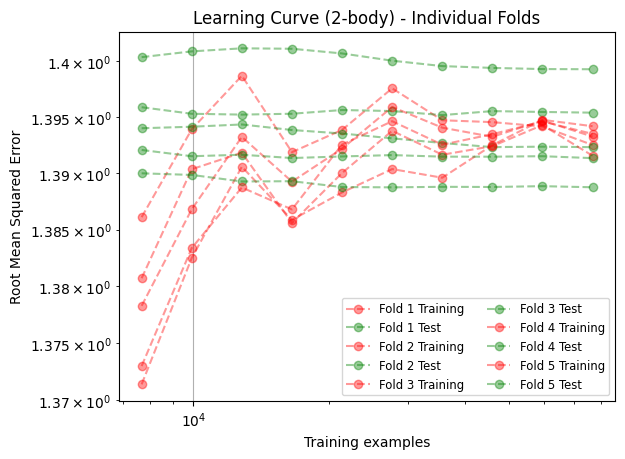

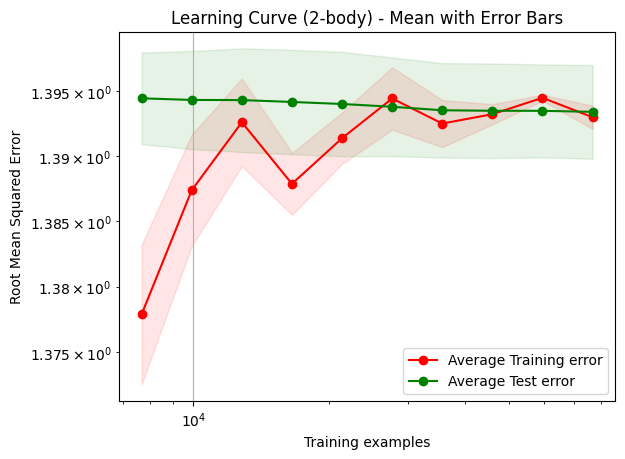

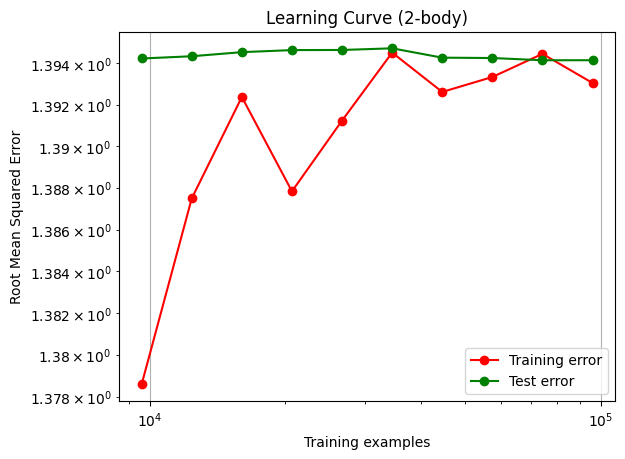

In [5]:
feature_choice = "2-body"  # Options: "2-body", "3-body", "4-body", "2+3-body", "2+3+4-body"
X_train, X_test, y_train, y_test = load_data(feature_choice)

plot_learning_curve_kfold(LinearRegression(), X_train, y_train, title=f"Learning Curve ({feature_choice})")
plot_learning_curve_with_test(LinearRegression(), X_train, X_test, y_train, y_test, title=f"Learning Curve ({feature_choice})")


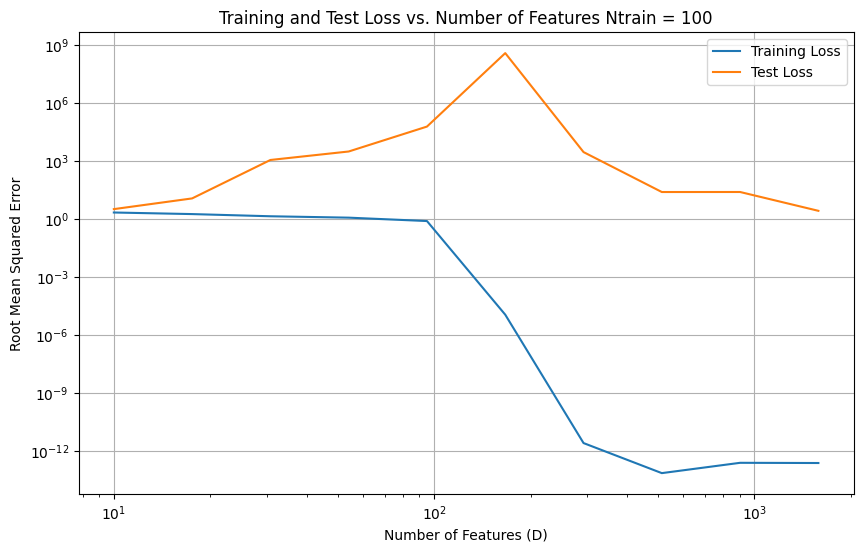

In [4]:

X, y = np.load(data_paths["3-body"]), np.load(data_paths["energies"])
X = (X - X.mean())/X.std()

Ntrain = 100
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=Ntrain, random_state=42)


train_loss = []
test_loss = []
D_values = np.logspace(np.log10(10), np.log10(1584), 10)


for D in D_values:
    D = int(D)
    model = LinearRegression()
    model.fit(X_train[:, :D], y_train)

    y_train_pred = model.predict(X_train[:, :D])
    train_rmse = np.sqrt(np.mean((y_train_pred - y_train) ** 2))
    train_loss.append(train_rmse)

    y_test_pred = model.predict(X_test[:, :D])
    test_rmse = np.sqrt(np.mean((y_test_pred - y_test) ** 2))
    test_loss.append(test_rmse)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(D_values, train_loss, label="Training Loss")
plt.plot(D_values, test_loss, label="Test Loss")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of Features (D)")
plt.ylabel("Root Mean Squared Error")
plt.title(f"Training and Test Loss vs. Number of Features Ntrain = {Ntrain}")
plt.legend()
plt.grid(True)
plt.show()